# Exploratory Analysis of Traffic Violations in Brazil (Years 2022 and 2023)
In this notebook, we will conduct an exploratory analysis of the data. This project was developed during a Data Viking event, and I made some modifications to the original code by using Spark to manipulate and analyze the data from 2023 as well.



# Data Ingestion


## Installing Spark on Google collab



In [1]:
#Install JDK
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
# Donwload Spark
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz

In [3]:
# Unzip spark folder
!tar xf /content/spark-3.1.2-bin-hadoop2.7.tgz

In [4]:
!pip install -q findspark

In [5]:
# Create env variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [6]:
# Import findspark, that helps find the Spark on the system and import as a regular lib
import findspark
findspark.init()

## Download Traffic Violations Data from the Brazil Government website


In [7]:
import re
# Let's first download the data from the government site, this is one of my updates on the tutor´s code
# I download the code automatically from the site
import requests
import zipfile

def download_and_extract_file(url, destination):
    response = requests.get(url)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
        print("File downloaded successfully.")

        # Extract the file
        with zipfile.ZipFile(destination, 'r') as zip_ref:
            zip_ref.extractall(os.path.dirname(destination))
        print("File extracted successfully.")

        # Delete the .zip file
        os.remove(destination)
        print(".zip file deleted.")
    else:
        print("Failed to download the file.")

In [8]:
# Create the data folder as I want the downloaded files stored there
folder_name = "data"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'data' created successfully.


In [9]:
# Download 2022 traffic violation data
file_url = 'https://drive.google.com/u/0/uc?id=1-oY2e1W4cjmbZCgdcGnmPCIod4MFCSpg&export=download&confirm=t&uuid=c1ebf929-8b62-4489-a46d-5284482747fb&at=AKKF8vwfciU3oT68KlBtF4jj14Wl:1688604985049'
file_destination = '/content/data/infracoes_2022.zip'

download_and_extract_file(file_url, file_destination)

File downloaded successfully.
File extracted successfully.
.zip file deleted.


In [10]:
# Download 2023 traffic violation data
file_url = 'https://drive.google.com/u/0/uc?id=106pwbYv84gCtLhhcbi0B_4qyUQxfH2n3&export=download&confirm=t&uuid=3967f839-2af2-437b-8f60-bb84c592767d&at=AKKF8vxhyEJdMfwlL_zzAfR9M7ZO:1688605862920'
file_destination = '/content/data/infracoes_2023.zip'

download_and_extract_file(file_url, file_destination)

File downloaded successfully.
File extracted successfully.
.zip file deleted.


## Creating our Spark Dataframes
After downloading the files, let's create a Spark dataframe that includes all the CSV files that were downloaded.

In [11]:
from pyspark.sql import SparkSession
import os

def create_dataframe_with_file_content(directory_path):
    # List the files in the directory
    files = os.listdir(directory_path)

    # Create an empty list to store the DataFrames
    dataframes = []
    print("Processing files:")
    # Loop to consolidate the files
    for counter, file_name in enumerate(files):
        print(counter, file_name)

        # Read the file into a DataFrame
        file_path = os.path.join(directory_path, file_name)
        base_data = spark.read.format("csv").option("header", "true").option("sep", ";").option("encoding", "latin1").load(file_path)

        # Append the DataFrame to the list
        dataframes.append(base_data)

    # Union all the DataFrames in the list
    consolidated_data = dataframes[0]
    for i in range(1, len(dataframes)):
        consolidated_data = consolidated_data.union(dataframes[i])

    # Get the shape of the consolidated DataFrame
    print("Files content were consolidated.")
    print((consolidated_data.count(), len(consolidated_data.columns)))
    print("")
    return consolidated_data

In [12]:
# Create a SparkSession
spark = SparkSession.builder\
        .master('local')\
        .appName('TVextraction')\
        .getOrCreate()

# Creating Traffic violation 2022 dataframe
TV22 = create_dataframe_with_file_content('/content/data/ajustados_2022')

Processing files:
0 infraçoes2022_11.csv
1 infraçoes2022_10.csv
2 infraçoes2022_07.csv
3 infraçoes2022_01.csv
4 infraçoes2022_02.csv
5 infraçoes2022_12.csv
6 infraçoes2022_06.csv
7 infraçoes2022_09.csv
8 infraçoes2022_05.csv
9 infraçoes2022_04.csv
10 infraçoes2022_08.csv
11 infraçoes2022_03.csv
Files content were consolidated.
(4135523, 25)



In [13]:
# Checking columns types of 2022 data
TV22.printSchema()

root
 |-- Número do Auto: string (nullable = true)
 |-- Data da Infração (DD/MM/AAAA): string (nullable = true)
 |-- Indicador de Abordagem: string (nullable = true)
 |-- Assinatura do Auto: string (nullable = true)
 |-- Sentido Trafego: string (nullable = true)
 |-- UF Infração: string (nullable = true)
 |-- BR Infração: string (nullable = true)
 |-- Km Infração: string (nullable = true)
 |-- Município: string (nullable = true)
 |-- Indicador Veiculo Estrangeiro: string (nullable = true)
 |-- UF Placa: string (nullable = true)
 |-- Descrição Especie Veículo: string (nullable = true)
 |-- Descrição Marca Veículo: string (nullable = true)
 |-- Descrição Tipo Veículo: string (nullable = true)
 |-- Descrição Modelo Veiculo: string (nullable = true)
 |-- Código da Infração: string (nullable = true)
 |-- Descrição Abreviada Infração: string (nullable = true)
 |-- Enquadramento da Infração: string (nullable = true)
 |-- Início Vigência da Infração: string (nullable = true)
 |-- Fim Vigência 

In [14]:
# Checking 2022 data
TV22.show(10)

+---------------+-----------------------------+----------------------+------------------+---------------+-----------+-----------+-----------+--------------+-----------------------------+--------+-------------------------+-----------------------+----------------------+------------------------+------------------+----------------------------+-------------------------+---------------------------+---------------------+----------------+-------------+-------------------+------------------+-------------+
| Número do Auto|Data da Infração (DD/MM/AAAA)|Indicador de Abordagem|Assinatura do Auto|Sentido Trafego|UF Infração|BR Infração|Km Infração|     Município|Indicador Veiculo Estrangeiro|UF Placa|Descrição Especie Veículo|Descrição Marca Veículo|Descrição Tipo Veículo|Descrição Modelo Veiculo|Código da Infração|Descrição Abreviada Infração|Enquadramento da Infração|Início Vigência da Infração|Fim Vigência Infração|Medição Infração|Hora Infração|Medição Considerada|Excesso Verificado|Qtd Infraçõ

In [15]:
# Creating Traffic violation 2023 dataframe
TV23 = create_dataframe_with_file_content('/content/data/ajustados_2023')

Processing files:
0 infraçoes2023_05.csv
1 infraçoes2023_02.csv
2 infraçoes2023_03.csv
3 infraçoes2023_04.csv
4 infraçoes2023_01.csv
Files content were consolidated.
(2105730, 25)



In [16]:
# Checking columns types of 2023 data
TV23.printSchema()

root
 |-- Número do Auto: string (nullable = true)
 |-- Data da Infração (DD/MM/AAAA): string (nullable = true)
 |-- Indicador de Abordagem: string (nullable = true)
 |-- Assinatura do Auto: string (nullable = true)
 |-- Sentido Trafego: string (nullable = true)
 |-- UF Infração: string (nullable = true)
 |-- BR Infração: string (nullable = true)
 |-- Km Infração: string (nullable = true)
 |-- Município: string (nullable = true)
 |-- Indicador Veiculo Estrangeiro: string (nullable = true)
 |-- UF Placa: string (nullable = true)
 |-- Descrição Especie Veículo: string (nullable = true)
 |-- Descrição Marca Veículo: string (nullable = true)
 |-- Descrição Tipo Veículo: string (nullable = true)
 |-- Descrição Modelo Veiculo: string (nullable = true)
 |-- Código da Infração: string (nullable = true)
 |-- Descrição Abreviada Infração: string (nullable = true)
 |-- Enquadramento da Infração: string (nullable = true)
 |-- Início Vigência da Infração: string (nullable = true)
 |-- Fim Vigência 

In [17]:
# Checking columns types of 2023 data
TV23.show(10)

+---------------+-----------------------------+----------------------+------------------+---------------+-----------+-----------+-----------+---------+-----------------------------+--------+-------------------------+-----------------------+----------------------+------------------------+------------------+----------------------------+-------------------------+---------------------------+---------------------+----------------+-------------+-------------------+------------------+-------------+
| Número do Auto|Data da Infração (DD/MM/AAAA)|Indicador de Abordagem|Assinatura do Auto|Sentido Trafego|UF Infração|BR Infração|Km Infração|Município|Indicador Veiculo Estrangeiro|UF Placa|Descrição Especie Veículo|Descrição Marca Veículo|Descrição Tipo Veículo|Descrição Modelo Veiculo|Código da Infração|Descrição Abreviada Infração|Enquadramento da Infração|Início Vigência da Infração|Fim Vigência Infração|Medição Infração|Hora Infração|Medição Considerada|Excesso Verificado|Qtd Infrações|
+-----

## Saving the DataFrame as Parquet

During the event, we studied different file formats for saving the data, and it was found that the .parquet format is the lightest among the ones studied (csv, db, and parquet).
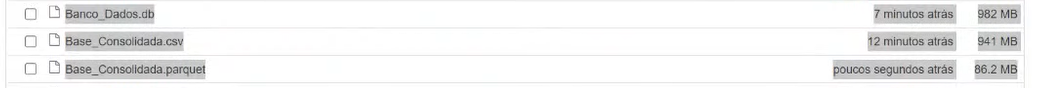
For this reason, we chose to save the file in .parquet format.

In [18]:
from pyspark.sql.functions import col

def df_to_parquet(consolidated_data, file_path):
  # Convert columns to string type
  for col_name in consolidated_data.columns:
      # Remove invalid characters from the column name
      new_col_name = col_name.replace(" ", "_").replace(",", "").replace(";", "").replace("{", "").replace("}", "").replace("(", "").replace(")", "").replace("\n", "").replace("\t", "").replace("=", "")
      # Rename the column
      consolidated_data = consolidated_data.withColumnRenamed(col_name, new_col_name).withColumn(new_col_name, col(new_col_name).cast("string"))

  consolidated_data.write.parquet(file_path, compression="gzip")
  print("Parquet file was created and saved on " + file_path)

In [19]:
# Create the datalake folder, where I will save some of the dataframes stored there
folder_name = "datalake/bronze"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'datalake/bronze' created successfully.


In [20]:
# Save the TV22 dataFrame as a Parquet file
df_to_parquet(TV22,"/content/datalake/bronze/traffic_violations_2022.parquet")

Parquet file was created and saved on /content/datalake/bronze/traffic_violations_2022.parquet


In [21]:
# Save the TV23 dataFrame as a Parquet file
df_to_parquet(TV23,"/content/datalake/bronze/traffic_violations_2023.parquet")

Parquet file was created and saved on /content/datalake/bronze/traffic_violations_2023.parquet


In [22]:
# Close the SparkSession of Extraction
# I don't want to use the same spark context on the next steps, I want to make sure that the code will import data from the parquet file
spark.stop()

# Exploratory Data Analysis 2022

### Import parquet files
Let´s import the parquet files and save on spark dataframes.

In [23]:
# Import Traffic violation parquet files as a spark dataframe

# Create a SparkSession
spark = SparkSession.builder\
        .master('local')\
        .appName('TVanalysis')\
        .getOrCreate()

# Read 2022 traffic violations
TV22 = spark.read.parquet("/content/datalake/bronze/traffic_violations_2022.parquet")
# TV22 Shape
print("2022 Traffic violations Dataframe shape:")
print((TV22.count(), len(TV22.columns)))

2022 Traffic violations Dataframe shape:
(4135523, 25)


In [24]:
# Making sure the dataframe type
print("Dataframe type:")
type(TV22)

Dataframe type:


pyspark.sql.dataframe.DataFrame

### Translating the header from Portuguese to English
The intention is making this notebook understable for everyone.

In [25]:
# Define a translation dictionary for column translations
translation_dict = {
    "Número_do_Auto": "Auto_Number",
    "Data_da_Infração_DD/MM/AAAA": "Date_of_Violation_DD/MM/YYYY",
    "Indicador_de_Abordagem": "Approach_Indicator",
    "Assinatura_do_Auto": "Auto_Signature",
    "Sentido_Trafego": "Traffic_Direction",
    "UF_Infração": "Infraction_State",
    "BR_Infração": "Infraction_BR",
    "Km_Infração": "Infraction_Km",
    "Município": "City",
    "Indicador_Veiculo_Estrangeiro": "Foreign_Vehicle_Indicator",
    "UF_Placa": "License_Plate_State",
    "Descrição_Especie_Veículo": "Vehicle_Species_Description",
    "Descrição_Marca_Veículo": "Vehicle_Brand_Description",
    "Descrição_Tipo_Veículo": "Vehicle_Type_Description",
    "Descrição_Modelo_Veiculo": "Vehicle_Model_Description",
    "Código_da_Infração": "Infraction_Code",
    "Descrição_Abreviada_Infração": "Abbreviated_Infraction_Description",
    "Enquadramento_da_Infração": "Infraction_Framing",
    "Início_Vigência_da_Infração": "Infraction_Start_Vigency",
    "Fim_Vigência_Infração": "Infraction_End_Vigency",
    "Medição_Infração": "Infraction_Measurement",
    "Hora_Infração": "Infraction_Time",
    "Medição_Considerada": "Considered_Measurement",
    "Excesso_Verificado": "Verified_Excess",
    "Qtd_Infrações": "Infraction_Quantity"
}

# Translate the column names
TV22 = TV22.select(
    *[col(c).alias(translation_dict.get(c, c)) for c in TV22.columns]
)

In [26]:
# Checking dataframe schema
print("2022 Traffic violations Dataframe schema:")
TV22.printSchema()

2022 Traffic violations Dataframe schema:
root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: string (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: 

### Checking unique and null values on each column
We will also check the total infractions.

In [27]:
from pyspark.sql.functions import col, sum as spark_sum
# Count the number of null values in each column
null_counts = TV22.select([spark_sum(col(c).isNull().cast("integer")).alias(c) for c in TV22.columns])
# Display the null counts
print("Count the number of null values in each column:")
null_counts.show()

Count the number of null values in each column:
+-----------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+----+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measurement|Infr

In [28]:
from pyspark.sql.functions import countDistinct
# Calculate the number of unique values in each column
nunique_counts = TV22.agg(*[countDistinct(col_name).alias(col_name) for col_name in TV22.columns])
# Display the number of unique values
print("Calculate the number of unique values in each column:")
nunique_counts.show()

Calculate the number of unique values in each column:
+-----------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+----+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measuremen

In [29]:
# Get the total number of rows
total_multa = int(TV22.count())
# Print the total number of multas
print(f'Total of 2022 Traffic Violations: {total_multa}')

Total of 2022 Traffic Violations: 4135523


### Converting the column Data_of_Violation to Date Format

In [30]:
from pyspark.sql.functions import col, to_date
# Convert the column to date type
TV22 = TV22.withColumn('Date_of_Violation_DD/MM/YYYY', to_date(col('Date_of_Violation_DD/MM/YYYY'), 'yyyy-MM-dd'))
# Print the updated data type of the column
TV22.printSchema()

root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_End

### Getting the total of Violations on a day of the year
The goal is getting the total violation on a day, along with the moving avarage.

In [31]:
from pyspark.sql.functions import expr
from pyspark.sql.window import Window

# Creating a temporary view called TV22
TV22.createOrReplaceTempView("TV22")

# Creating a query, to get the contect from the temp view
query = "SELECT\
            `Date_of_Violation_DD/MM/YYYY` AS `Date`, \
            COUNT(*) AS `Violations_Count`, \
            MONTH(`Date_of_Violation_DD/MM/YYYY`) AS `Month`, \
            DAY(`Date_of_Violation_DD/MM/YYYY`) AS `Day`\
        FROM \
            TV22 \
        GROUP BY \
            `Date_of_Violation_DD/MM/YYYY` \
        ORDER BY \
            `Date_of_Violation_DD/MM/YYYY`"

# run the query and storying in another variable called flights10
violations_per_day = spark.sql(query)

# Get the moving avarage
window_spec = Window.orderBy("Date").rowsBetween(-6, 0)
violations_per_day = violations_per_day.withColumn("moving_avarage", expr("avg(Violations_Count)").over(window_spec))

# see result
violations_per_day.show(10)

+----------+----------------+-----+---+------------------+
|      Date|Violations_Count|Month|Day|    moving_avarage|
+----------+----------------+-----+---+------------------+
|2022-01-01|            8533|    1|  1|            8533.0|
|2022-01-02|           13146|    1|  2|           10839.5|
|2022-01-03|           12012|    1|  3|11230.333333333334|
|2022-01-04|           11248|    1|  4|          11234.75|
|2022-01-05|           11159|    1|  5|           11219.6|
|2022-01-06|           10167|    1|  6|11044.166666666666|
|2022-01-07|           11150|    1|  7|11059.285714285714|
|2022-01-08|            8321|    1|  8|           11029.0|
|2022-01-09|            8788|    1|  9| 10406.42857142857|
|2022-01-10|            8520|    1| 10|  9907.57142857143|
+----------+----------------+-----+---+------------------+
only showing top 10 rows



In [32]:
violations_per_day.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Violations_Count: long (nullable = false)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- moving_avarage: double (nullable = true)



### Install plotly
We will install Plotly to leverage its powerful visualization capabilities for our exploratory analysis.

In [33]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
!pip install plotly

To generate the charts using Plotly we need to conver the Spark dataframes on Pandas Dataframes

In [35]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_violations_per_day = violations_per_day.toPandas()

### Create our first line chart
We plotly the df_violations_per_day dataframe, on a line chart.

In [36]:
px.line(
    df_violations_per_day,
    x='Date',
    y='Violations_Count'
)

### Creating a Box Plot
On this chart we want to check the outliers for each month.

**Month with more outliers: October and June**

**Month with the best median: November**

In [37]:
# Boxplot
px.box(
    df_violations_per_day,
    x='Month',
    y='Violations_Count',
    color='Month',
    title='Tickets per Month Distribution'
)

### Creating a Grid System
Just for earning pourposes we will create a grid system, we will create two charts date x violations count and date x moving avarage

In [38]:
# Grid System

# Grid
Grid = make_subplots( rows=1, cols= 2 )

# Graph 1
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['Violations_Count'],
        mode='lines',
        name='Violations Count'
    ),
    row=1, col=1
)

# Graph 2
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['moving_avarage'],
        mode='lines',
        name='Moving Avarage'
    ),
    row=1, col=2
)

# Layout Adjust
Grid.update_layout(

    # title
    title='Traffic Violation Analyses per Day - Grid System',

    # legend
    showlegend=True,

    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

Grid

### Overlaying the charts
By overlaying the charts we will be able to check the charts on the grid system on the same chart

In [39]:
# Grid
Grid = make_subplots( rows=1, cols= 1 )

# Graph 1
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['Violations_Count'],
        mode='lines',
        name='Violations Count'
    ),
    row=1, col=1
)

# Graph 2
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['moving_avarage'],
        mode='lines',
        name='Moving Avarage'
    ),
    row=1, col=1
)

# Layout Adjust
Grid.update_layout(

    # Title
    title='Traffic Violation Analyses per Day',

    # Legend
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

Grid

### Lets have a closer look on the Brazilian States
How many infractions were registered on each state?
We will also get the percentage of infractions for each state compared with all registered infractions and get the cumulative percentange.

In [40]:
from pyspark.sql.functions import count, sum
from pyspark.sql.window import Window

# Calculate the sum of infractions by state
violations_per_state = TV22.groupBy('Infraction_State').agg(count('*').alias('Violations_Count'))

# Calculate the percentage of infractions for each state
state_percent = (TV22.groupBy("Infraction_State").agg((count("*") / TV22.count()).alias("%violations_Count"))).orderBy(col("%violations_Count").desc())

# Calculate the percentage of infractions for each state (cummulative)
windowSpec = Window.orderBy(col("%violations_Count").desc())
cum_stata_percent= (
    state_percent
    .withColumn("cumulative_sum", sum("%violations_Count").over(windowSpec))
)

# Join the calculated frequencies with the violations_per_state DataFrame
violations_per_state = violations_per_state.join(cum_stata_percent, "Infraction_State", "left").orderBy(col("%violations_Count").desc())

# Print the DataFrame
violations_per_state.show(27)

+----------------+----------------+--------------------+-------------------+
|Infraction_State|Violations_Count|   %violations_Count|     cumulative_sum|
+----------------+----------------+--------------------+-------------------+
|              MG|          448672| 0.10849220279998442|0.10849220279998442|
|              RJ|          418981| 0.10131269974801252|0.20980490254799694|
|              BA|          417092| 0.10085592559876949|0.31066082814676643|
|              SP|          378074| 0.09142108507194859|  0.402081913218715|
|              RS|          252059| 0.06094972751934882| 0.4630316407380638|
|              MS|          248186| 0.06001320751933915| 0.5230448482574029|
|              PR|          237359| 0.05739515896780165| 0.5804400072252046|
|              GO|          230375| 0.05570637619474006| 0.6361463834199447|
|              SC|          178040| 0.04305138672907877| 0.6791977701490235|
|              MT|          172734| 0.04176835674713936| 0.7209661268961629|

By checking the last collumn (cumulative_sum) we can see that 4 states represent 50% of all registered infractions.

In [41]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_violations_per_state = violations_per_state.toPandas()

In [42]:
df_violations_per_state.head()

,Infraction_State,Violations_Count,%violations_Count,cumulative_sum
0,MG,448672,0.108492,0.108492
1,RJ,418981,0.101313,0.209805
2,BA,417092,0.100856,0.310661
3,SP,378074,0.091421,0.402082
4,RS,252059,0.060950,0.463032


In [43]:
# Funnel Chart
px.funnel(
    df_violations_per_state[ df_violations_per_state['cumulative_sum'] < 0.5 ],
    y='Infraction_State',
    x='Violations_Count',
    title='State Concentration of 50% Traffic Infractions'
)

In [44]:
px.bar(
    df_violations_per_state,
    x='Infraction_State',
    y='cumulative_sum',
    title='Accumulated Infraction by state'
)

In [45]:
TV22.printSchema()

root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_End

### Checking the number of infractions for each month on every state
We want to check if in some month of the year some states register more infractions that others.

We will generate heatmap with the data.

In [46]:
# Creating a query, to get the contect from the temp view
query = "SELECT * \
        FROM \
            TV22"

query = "SELECT\
            `Infraction_State` AS `State`, \
            COUNT(*) AS `Violations_Count`, \
            MONTH(`Date_of_Violation_DD/MM/YYYY`) AS `Month` \
        FROM \
            TV22 \
        GROUP BY \
            `Infraction_State`, `Month` \
        ORDER BY \
            `Month`"

# run the query and storying in another variable
violations_month_state = spark.sql(query)

# see result
violations_month_state.show()

+-----+----------------+-----+
|State|Violations_Count|Month|
+-----+----------------+-----+
|   RS|           21648|    1|
|   RN|            5390|    1|
|   RR|             931|    1|
|   SP|           35375|    1|
|   PR|           28441|    1|
|   AC|            1935|    1|
|   DF|            3789|    1|
|   MS|           19957|    1|
|   ES|            9814|    1|
|   AP|            1065|    1|
|   PB|            8921|    1|
|   BA|           29613|    1|
|   MT|           15282|    1|
|   TO|            3320|    1|
|   SE|            3347|    1|
|   CE|           11819|    1|
|   MA|            6152|    1|
|   MG|           25886|    1|
|   RJ|           47616|    1|
|   PI|            6897|    1|
+-----+----------------+-----+
only showing top 20 rows



In [47]:
# Perform the pivot operation
pivot_violations_month_state = violations_month_state.groupBy("Month").pivot("State").sum("Violations_Count")

# Show the resulting DataFrame
pivot_violations_month_state.show()

+-----+----+----+----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+----+-----+-----+-----+-----+----+----+----+-----+-----+----+-----+----+
|Month|  AC|  AL|  AM|  AP|   BA|   CE|   DF|   ES|   GO|  MA|   MG|   MS|   MT|  PA|  PB|   PE|   PI|   PR|   RJ|  RN|  RO|  RR|   RS|   SC|  SE|   SP|  TO|
+-----+----+----+----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+----+-----+-----+-----+-----+----+----+----+-----+-----+----+-----+----+
|   12| 992|3353|1881|2441|36934| 7253| 5360| 6001|18423|7123|39532|32609|17395|6727|5533|10972| 5969|19881|25031|7346|6909|1090|30135|16466|2932|39002|3575|
|    1|1935|4145|1960|1065|29613|11819| 3789| 9814|12965|6152|25886|19957|15282|4518|8921| 9599| 6897|28441|47616|5390|7160| 931|21648| 9393|3347|35375|3320|
|    6|1199|2133|1780|1048|33048| 7611| 7566|15296|18386|4014|39351|15812|14364|5398|5165| 9545| 5515|12865|47713|5028|7654| 610|15623|14244|1053|29731|3272|
|    3|1626|3892|1451|1136|38322|12586| 7749| 9687|2

In [48]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_pivot_violations_month_state = pivot_violations_month_state.toPandas()

In [49]:
df_pivot_violations_month_state

,Month,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,12,992,3353,1881,2441,36934,7253,5360,6001,18423,...,19881,25031,7346,6909,1090,30135,16466,2932,39002,3575
1,1,1935,4145,1960,1065,29613,11819,3789,9814,12965,...,28441,47616,5390,7160,931,21648,9393,3347,35375,3320
2,6,1199,2133,1780,1048,33048,7611,7566,15296,18386,...,12865,47713,5028,7654,610,15623,14244,1053,29731,3272
3,3,1626,3892,1451,1136,38322,12586,7749,9687,26626,...,25538,45218,7639,9425,1255,23029,14372,3806,34265,3950
4,5,1056,2950,1658,1599,28583,11562,9927,14337,22472,...,18577,41165,6086,8190,703,19892,17870,3193,21472,3518
5,9,1082,4449,1801,1626,34947,10264,3117,16495,17573,...,15283,20197,7185,9287,1013,19967,16094,3539,30824,2282
6,4,1178,4175,2049,1670,42969,15011,13708,12860,25979,...,21734,48050,6544,8750,1523,23871,17591,3901,22893,3168
7,8,1109,2560,1520,1177,34006,10619,3562,15743,17892,...,16044,22501,6374,9161,907,18305,14365,2660,31345,2702
8,7,1491,1610,1450,876,32852,6897,8809,14789,18359,...,16983,36345,5192,6754,538,14714,12415,2429,31650,2698
9,10,1339,3767,1361,1827,41016,11813,3465,16637,16130,...,17804,24220,7429,7893,921,21528,17167,3874,35017,3019


In [50]:
px.imshow(
    df_pivot_violations_month_state,
    title=' Heatmap | Monthly Traffic Violations by State 2022')

### Checking the infraction type
Each infraction has more cost to the infractor, we will download the ticket value data for each infraction and map how much each state has earned on infractions using the join function.

In [51]:
# Compute the cumulative percentage
violation_type = TV22.select('Infraction_Framing') \
    .groupBy('Infraction_Framing') \
    .count() \
    .withColumn('cumulative_count', sum('count').over(Window.orderBy(col("count").desc()))) \
    .withColumn('cumulative_percentage', col('cumulative_count') / sum('count').over(Window.partitionBy()) * 100)

# Show the resulting DataFrame
violation_type.show(5)

+------------------+-------+----------------+---------------------+
|Infraction_Framing|  count|cumulative_count|cumulative_percentage|
+------------------+-------+----------------+---------------------+
|             218 I|1093345|         1093345|   26.437889476131556|
|               167| 228723|         1322068|   31.968580515692935|
|             203 V| 206200|         1528268|    36.95464878323733|
|           230 * V| 204476|         1732744|      41.899029457701|
|            218 II| 182358|         1915102|   46.308580559218264|
+------------------+-------+----------------+---------------------+
only showing top 5 rows



In [52]:
# Loop no site do Detran e buscar os dados
Url = 'https://www.detran.mg.gov.br/infracoes/consultar-tipos-infracoes/index/index/index/index/index/index/index/index/index/index/index/index/index/lista-de-infracoes?artigo=&descricao=&page='

# Tabela vazia
df_violation_ticket_value = pd.DataFrame()

for Loop in range(1, 24):

    # Construindo a URL
    Link = f'{Url}{Loop}'

    # Lendo os dados da Web
    web_data = pd.read_html(Link)[0]

    # Consolidar
    df_violation_ticket_value = pd.concat([df_violation_ticket_value, web_data])

In [53]:
# Define a translation dictionary for column translations
translation_dict = {
    "Código": "Code",
    "Desd.": "Desd.",
    "Infração": "Infraction",
    "Artigo": "Article",
    "Infrator": "Offender",
    "Pts": "Points",
    "Valor": "Ticket_Value"
}

df_violation_ticket_value = df_violation_ticket_value.rename(columns=translation_dict)

In [54]:
df_violation_ticket_value.head()

,Code,Desd.,Infraction,Article,Offender,Points,Ticket_Value
0,5622,4,PARAR NOS CANTEIROS CENTRAIS OU DIVISORES DE P...,182 * VI,CON,3,8838
1,5622,5,PARAR NAS MARCAS DE CANALIZACAO,182 * VI,CON,3,8838
2,5630,0,PARAR NA AREA DE CRUZAMENTO DE VIAS,182 * VII,CON,4,13016
3,5649,1,PARAR NOS VIADUTOS,182 * VIII,CON,4,13016
4,5649,2,PARAR NAS PONTES,182 * VIII,CON,4,13016


In [55]:
df_violation_ticket_value['Ticket_Value'] = pd.to_numeric(df_violation_ticket_value['Ticket_Value'], errors='coerce')
df_violation_ticket_value['Ticket_Value'] = df_violation_ticket_value['Ticket_Value'] / 100

In [56]:
df_violation_ticket_value.head()

,Code,Desd.,Infraction,Article,Offender,Points,Ticket_Value
0,5622,4,PARAR NOS CANTEIROS CENTRAIS OU DIVISORES DE P...,182 * VI,CON,3,88.38
1,5622,5,PARAR NAS MARCAS DE CANALIZACAO,182 * VI,CON,3,88.38
2,5630,0,PARAR NA AREA DE CRUZAMENTO DE VIAS,182 * VII,CON,4,130.16
3,5649,1,PARAR NOS VIADUTOS,182 * VIII,CON,4,130.16
4,5649,2,PARAR NAS PONTES,182 * VIII,CON,4,130.16


In [57]:
df_violation_ticket_value.rename( columns={'Code':'Infraction_Code'}, inplace=True )

In [58]:
# Infraction_Code has more than 1 type on infraction, when we try to merge all tables the repeted data will be duplicate
# Grouping by the violation code and getting the mean value will prevent this to happen
ticket_value = df_violation_ticket_value.groupby( by=['Infraction_Code'] ).mean()['Ticket_Value'].reset_index()

<ipython-input-58-9eafc3d8502d>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [59]:
TV22.show(5)

+---------------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+-------+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|    Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|   City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measurement|Infraction_Time|Considered_Measurement

In [60]:
ticket_value.head()

,Infraction_Code,Ticket_Value
0,5002,0.00
1,5010,880.41
2,5029,880.41
3,5037,586.94
4,5045,293.47


In [61]:
# The infraction code is different on the tables, by doing some search we discover that the last extra digit that exists on TV22 table is useless
# We can proceed removing it
TV22 = TV22.withColumn('Infraction_Code', col('Infraction_Code').substr(1, 4))
# Change the column value to int
TV22 = TV22.withColumn("Infraction_Code", col("Infraction_Code").cast("int"))

In [62]:
# Transform ticket_value into a Spark Dataframe
violation_ticket_value = spark.createDataFrame(ticket_value)

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:331: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [63]:
# Alter the columns type
# To match with the TV22 columns and perform the join later
violation_ticket_value = violation_ticket_value.withColumn("Infraction_Code", col("Infraction_Code").cast("int"))
# Change the NaN values to 0 and the columns type to float in order to sum up values later
violation_ticket_value = violation_ticket_value.withColumn("Ticket_Value", col("Ticket_Value").cast("float"))
violation_ticket_value = violation_ticket_value.na.fill(0, subset=["Ticket_Value"])

In [64]:
violation_ticket_value.printSchema()

root
 |-- Infraction_Code: integer (nullable = true)
 |-- Ticket_Value: float (nullable = false)



In [65]:
# Join tables violation_ticket_value and TV22
TV22 = TV22.join(violation_ticket_value, on='Infraction_Code', how='left')

In [66]:
TV22.printSchema()

root
 |-- Infraction_Code: integer (nullable = true)
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_En

In [67]:
# Create another dataframe, where we will group by State
uf_tickets_value = TV22.groupBy('Infraction_State').agg(
    count('Ticket_Value').alias('Violations_Count'),
    sum('Ticket_Value').alias('Total_ticket_value')
)

In [68]:
uf_tickets_value.show(5)

+----------------+----------------+--------------------+
|Infraction_State|Violations_Count|  Total_ticket_value|
+----------------+----------------+--------------------+
|              SC|          178040|  3.88509024023819E7|
|              RO|           93105|2.0328607025260925E7|
|              PI|           85095| 2.318876397544861E7|
|              AM|           20102|   4812790.681762695|
|              RR|           12033|   3387469.271133423|
+----------------+----------------+--------------------+
only showing top 5 rows



In [69]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_uf_tickets_value = uf_tickets_value.toPandas()

In [70]:
px.scatter(
    df_uf_tickets_value,
    x='Violations_Count',
    y='Total_ticket_value',
    color='Infraction_State',
    size='Violations_Count',
    log_x=True,
    size_max=60,
    title='Bubble PLOT' )

In [71]:
# Create another dataframe to check the ticket earned in each month

from pyspark.sql.functions import col, month

# Create a new column 'Month' extracting the month from the 'Data' column
TV22 = TV22.withColumn('Month', month(col('Date_of_Violation_DD/MM/YYYY')))

# Perform the group by and sum operation
Month_ticket_value = TV22.groupBy('Month').agg(spark_sum('Ticket_Value').alias('Ticket_Value')).orderBy('Month')

Month_ticket_value.show()


+-----+--------------------+
|Month|        Ticket_Value|
+-----+--------------------+
|    1| 7.134070206180573E7|
|    2|  8.34084510411148E7|
|    3|  8.64017058329773E7|
|    4| 8.685282327345276E7|
|    5| 7.579054229421997E7|
|    6| 6.787070042235565E7|
|    7|6.4246813547180176E7|
|    8| 6.834306110219574E7|
|    9| 7.236468826558685E7|
|   10| 7.930838055548859E7|
|   11| 5.971798238167572E7|
|   12| 7.934042027719116E7|
+-----+--------------------+



### Saving the created dataframes on the datalake folder following the medallion architecture

Creating the folders

In [72]:
# Create the datalake folder, where I will save some of the dataframes stored there
folder_name = "datalake/silver"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'datalake/silver' created successfully.


In [73]:
# Create the datalake folder, where I will save some of the dataframes stored there
folder_name = "datalake/gold"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'datalake/gold' created successfully.


Saving the dataframes TV22 and TV22 as parquet files on the silver folder, these dataframes are the ones that have all data, but they are treated.

In [74]:
df_to_parquet(TV22,"/content/datalake/silver/traffic_violations_2022.parquet")

Parquet file was created and saved on /content/datalake/silver/traffic_violations_2022.parquet


In [75]:
violations_per_day.write.csv("/content/datalake/gold/violations_per_day_2022.csv")
violations_per_state.write.csv("/content/datalake/gold/violations_per_state_2022.csv")
violations_month_state.write.csv("/content/datalake/gold/violations_month_state_2022.csv")
violation_type.write.csv("/content/datalake/gold/violation_type_2022.csv")
uf_tickets_value.write.csv("/content/datalake/gold/uf_tickets_value_2022.csv")
Month_ticket_value.write.csv("/content/datalake/gold/Month_ticket_value_2022.csv")

### Closing Spark Session

In [76]:
spark.stop()

# Exploratory Data Analysis 2023

### Import parquet files
Let´s import the parquet files and save on spark dataframes.

In [77]:
# Import Traffic violation parquet files as a spark dataframe

# Create a SparkSession
spark = SparkSession.builder\
        .master('local')\
        .appName('TVanalysis')\
        .getOrCreate()

# Read 2023 traffic violations
TV23 = spark.read.parquet("/content/datalake/bronze/traffic_violations_2023.parquet")
# TV23 Shape
print("2023 Traffic violations Dataframe shape:")
print((TV23.count(), len(TV23.columns)))

2023 Traffic violations Dataframe shape:
(2105730, 25)


In [78]:
# Making sure the dataframe type
print("Dataframe type:")
type(TV23)

Dataframe type:


pyspark.sql.dataframe.DataFrame

### Translating the header from Portuguese to English
The intention is making this notebook understable for everyone.

In [79]:
# Define a translation dictionary for column translations
translation_dict = {
    "Número_do_Auto": "Auto_Number",
    "Data_da_Infração_DD/MM/AAAA": "Date_of_Violation_DD/MM/YYYY",
    "Indicador_de_Abordagem": "Approach_Indicator",
    "Assinatura_do_Auto": "Auto_Signature",
    "Sentido_Trafego": "Traffic_Direction",
    "UF_Infração": "Infraction_State",
    "BR_Infração": "Infraction_BR",
    "Km_Infração": "Infraction_Km",
    "Município": "City",
    "Indicador_Veiculo_Estrangeiro": "Foreign_Vehicle_Indicator",
    "UF_Placa": "License_Plate_State",
    "Descrição_Especie_Veículo": "Vehicle_Species_Description",
    "Descrição_Marca_Veículo": "Vehicle_Brand_Description",
    "Descrição_Tipo_Veículo": "Vehicle_Type_Description",
    "Descrição_Modelo_Veiculo": "Vehicle_Model_Description",
    "Código_da_Infração": "Infraction_Code",
    "Descrição_Abreviada_Infração": "Abbreviated_Infraction_Description",
    "Enquadramento_da_Infração": "Infraction_Framing",
    "Início_Vigência_da_Infração": "Infraction_Start_Vigency",
    "Fim_Vigência_Infração": "Infraction_End_Vigency",
    "Medição_Infração": "Infraction_Measurement",
    "Hora_Infração": "Infraction_Time",
    "Medição_Considerada": "Considered_Measurement",
    "Excesso_Verificado": "Verified_Excess",
    "Qtd_Infrações": "Infraction_Quantity"
}

# Translate the column names
TV23 = TV23.select(
    *[col(c).alias(translation_dict.get(c, c)) for c in TV23.columns]
)

In [80]:
# Checking dataframe schema
print("2023 Traffic violations Dataframe schema:")
TV23.printSchema()

2023 Traffic violations Dataframe schema:
root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: string (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: 

### Checking unique and null values on each column
We will also check the total infractions.

In [81]:
from pyspark.sql.functions import col, sum as spark_sum
# Count the number of null values in each column
null_counts = TV23.select([spark_sum(col(c).isNull().cast("integer")).alias(c) for c in TV23.columns])
# Display the null counts
print("Count the number of null values in each column:")
null_counts.show()

Count the number of null values in each column:
+-----------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+----+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measurement|Infr

In [82]:
from pyspark.sql.functions import countDistinct
# Calculate the number of unique values in each column
nunique_counts = TV23.agg(*[countDistinct(col_name).alias(col_name) for col_name in TV23.columns])
# Display the number of unique values
print("Calculate the number of unique values in each column:")
nunique_counts.show()

Calculate the number of unique values in each column:
+-----------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+----+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measuremen

In [83]:
# Get the total number of rows
total_multa = int(TV23.count())
# Print the total number of multas
print(f'Total of 2022 Traffic Violations: {total_multa}')

Total of 2022 Traffic Violations: 2105730


### Converting the column Data_of_Violation to Date Format

In [84]:
from pyspark.sql.functions import col, to_date
# Convert the column to date type
TV23 = TV23.withColumn('Date_of_Violation_DD/MM/YYYY', to_date(col('Date_of_Violation_DD/MM/YYYY'), 'yyyy-MM-dd'))
# Print the updated data type of the column
TV23.printSchema()

root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_End

### Getting the total of Violations on a day of the year
The goal is getting the total violation on a day, along with the moving avarage.

In [85]:
from pyspark.sql.functions import expr
from pyspark.sql.window import Window

# Creating a temporary view called TV23
TV23.createOrReplaceTempView("TV23")

# Creating a query, to get the contect from the temp view
query = "SELECT\
            `Date_of_Violation_DD/MM/YYYY` AS `Date`, \
            COUNT(*) AS `Violations_Count`, \
            MONTH(`Date_of_Violation_DD/MM/YYYY`) AS `Month`, \
            DAY(`Date_of_Violation_DD/MM/YYYY`) AS `Day`\
        FROM \
            TV23 \
        GROUP BY \
            `Date_of_Violation_DD/MM/YYYY` \
        ORDER BY \
            `Date_of_Violation_DD/MM/YYYY`"

# run the query and storying in another variable
violations_per_day = spark.sql(query)

# Get the moving avarage
window_spec = Window.orderBy("Date").rowsBetween(-6, 0)
violations_per_day = violations_per_day.withColumn("moving_avarage", expr("avg(Violations_Count)").over(window_spec))

# see result
violations_per_day.show(10)

+----------+----------------+-----+---+------------------+
|      Date|Violations_Count|Month|Day|    moving_avarage|
+----------+----------------+-----+---+------------------+
|2023-01-01|           10907|    1|  1|           10907.0|
|2023-01-02|           11276|    1|  2|           11091.5|
|2023-01-03|           12293|    1|  3|           11492.0|
|2023-01-04|           10635|    1|  4|          11277.75|
|2023-01-05|           10013|    1|  5|           11024.8|
|2023-01-06|           11531|    1|  6|11109.166666666666|
|2023-01-07|           10728|    1|  7|11054.714285714286|
|2023-01-08|            9993|    1|  8|10924.142857142857|
|2023-01-09|           10615|    1|  9|10829.714285714286|
|2023-01-10|           10434|    1| 10|10564.142857142857|
+----------+----------------+-----+---+------------------+
only showing top 10 rows



In [86]:
violations_per_day.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Violations_Count: long (nullable = false)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- moving_avarage: double (nullable = true)



### Install plotly
We will install Plotly to leverage its powerful visualization capabilities for our exploratory analysis.

In [87]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [88]:
!pip install plotly

To generate the charts using Plotly we need to conver the Spark dataframes on Pandas Dataframes

In [89]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_violations_per_day = violations_per_day.toPandas()

### Create our first line chart
We plotly the df_violations_per_day dataframe, on a line chart.

In [90]:
px.line(
    df_violations_per_day,
    x='Date',
    y='Violations_Count'
)

### Creating a Box Plot
On this chart we want to check the outliers for each month.

**Month with more outliers: March**

**Month with the best median: January**

In [91]:
# Boxplot
px.box(
    df_violations_per_day,
    x='Month',
    y='Violations_Count',
    color='Month',
    title='Tickets per Month Distribution'
)

### Creating a Grid System
Just for earning pourposes we will create a grid system, we will create two charts date x violations count and date x moving avarage

In [92]:
# Grid System

# Grid
Grid = make_subplots( rows=1, cols= 2 )

# Graph 1
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['Violations_Count'],
        mode='lines',
        name='Violations Count'
    ),
    row=1, col=1
)

# Graph 2
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['moving_avarage'],
        mode='lines',
        name='Moving Avarage'
    ),
    row=1, col=2
)

# Layout Adjust
Grid.update_layout(

    # title
    title='Traffic Violation Analyses per Day - Grid System',

    # legend
    showlegend=True,

    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

Grid

### Overlaying the charts
By overlaying the charts we will be able to check the charts on the grid system on the same chart

In [93]:
# Grid
Grid = make_subplots( rows=1, cols= 1 )

# Graph 1
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['Violations_Count'],
        mode='lines',
        name='Violations Count'
    ),
    row=1, col=1
)

# Graph 2
Grid.add_trace(
    go.Scatter(
        x=df_violations_per_day['Date'],
        y=df_violations_per_day['moving_avarage'],
        mode='lines',
        name='Moving Avarage'
    ),
    row=1, col=1
)

# Layout Adjust
Grid.update_layout(

    # Title
    title='Traffic Violation Analyses per Day',

    # Legend
    showlegend=True,
    legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    )
)

Grid

### Lets have a closer look on the Brazilian States
How many infractions were registered on each state?
We will also get the percentage of infractions for each state compared with all registered infractions and get the cumulative percentange.

In [94]:
from pyspark.sql.functions import count, sum
from pyspark.sql.window import Window

# Calculate the sum of infractions by state
violations_per_state = TV23.groupBy('Infraction_State').agg(count('*').alias('Violations_Count'))

# Calculate the percentage of infractions for each state
state_percent = (TV23.groupBy("Infraction_State").agg((count("*") / TV23.count()).alias("%violations_Count"))).orderBy(col("%violations_Count").desc())

# Calculate the percentage of infractions for each state (cummulative)
windowSpec = Window.orderBy(col("%violations_Count").desc())
cum_stata_percent= (
    state_percent
    .withColumn("cumulative_sum", sum("%violations_Count").over(windowSpec))
)

# Join the calculated frequencies with the violations_per_state DataFrame
violations_per_state = violations_per_state.join(cum_stata_percent, "Infraction_State", "left").orderBy(col("%violations_Count").desc())

# Print the DataFrame
violations_per_state.show(27)

+----------------+----------------+--------------------+-------------------+
|Infraction_State|Violations_Count|   %violations_Count|     cumulative_sum|
+----------------+----------------+--------------------+-------------------+
|              MG|          207213| 0.09840435383453719|0.09840435383453719|
|              ES|          185153|  0.0879281769267665|0.18633253076130368|
|              MT|          176889| 0.08400364719123535|0.27033617795253906|
|              SC|          176221|  0.0836864175369112|0.35402259548945025|
|              SP|          157641| 0.07486287415765554| 0.4288854696471058|
|              BA|          144563| 0.06865220137434525|  0.497537671021451|
|              PR|          131415|0.062408285962587795| 0.5599459569840388|
|              RJ|          128608| 0.06107525656185741| 0.6210212135458962|
|              RS|          128220| 0.06089099742132182| 0.6819122109672181|
|              MS|          126676| 0.06015776001671629| 0.7420699709839343|

By checking the last collumn (cumulative_sum) we can see that 6 states represent 50% of all registered infractions.

In [95]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_violations_per_state = violations_per_state.toPandas()

In [96]:
df_violations_per_state.head()

,Infraction_State,Violations_Count,%violations_Count,cumulative_sum
0,MG,207213,0.098404,0.098404
1,ES,185153,0.087928,0.186333
2,MT,176889,0.084004,0.270336
3,SC,176221,0.083686,0.354023
4,SP,157641,0.074863,0.428885


In [97]:
# Funnel Chart
px.funnel(
    df_violations_per_state[ df_violations_per_state['cumulative_sum'] < 0.5 ],
    y='Infraction_State',
    x='Violations_Count',
    title='State Concentration of 50% Traffic Infractions'
)

In [98]:
px.bar(
    df_violations_per_state,
    x='Infraction_State',
    y='cumulative_sum',
    title='Accumulated Infraction by state'
)

In [99]:
TV23.printSchema()

root
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Infraction_Code: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_End

### Checking the number of infractions for each month on every state
We want to check if in some month of the year some states register more infractions that others.

We will generate heatmap with the data.

In [100]:
# Creating a query, to get the contect from the temp view
query = "SELECT * \
        FROM \
            TV23"

query = "SELECT\
            `Infraction_State` AS `State`, \
            COUNT(*) AS `Violations_Count`, \
            MONTH(`Date_of_Violation_DD/MM/YYYY`) AS `Month` \
        FROM \
            TV23 \
        GROUP BY \
            `Infraction_State`, `Month` \
        ORDER BY \
            `Month`"

# run the query and storying in another variable
violations_month_state = spark.sql(query)

# see result
violations_month_state.show()

+-----+----------------+-----+
|State|Violations_Count|Month|
+-----+----------------+-----+
|   RS|           26305|    1|
|   PR|           21962|    1|
|   RR|             771|    1|
|   ES|            5592|    1|
|   AP|            1429|    1|
|   MT|           18112|    1|
|   AC|             745|    1|
|   MA|            5676|    1|
|   MG|           29338|    1|
|   SP|           32108|    1|
|   RJ|           19504|    1|
|   TO|            3358|    1|
|   BA|           35165|    1|
|   RN|            5612|    1|
|   DF|            3704|    1|
|   CE|            6747|    1|
|   PI|            5911|    1|
|   MS|           21665|    1|
|   SE|            3218|    1|
|   PB|            5474|    1|
+-----+----------------+-----+
only showing top 20 rows



In [101]:
# Perform the pivot operation
pivot_violations_month_state = violations_month_state.groupBy("Month").pivot("State").sum("Violations_Count")

# Show the resulting DataFrame
pivot_violations_month_state.show()

+-----+----+----+----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+----+-----+----+-----+-----+-----+----+----+-----+-----+----+-----+----+
|Month|  AC|  AL|  AM|  AP|   BA|   CE|   DF|   ES|   GO|  MA|   MG|   MS|   MT|  PA|  PB|   PE|  PI|   PR|   RJ|   RN|  RO|  RR|   RS|   SC|  SE|   SP|  TO|
+-----+----+----+----+----+-----+-----+-----+-----+-----+----+-----+-----+-----+----+----+-----+----+-----+-----+-----+----+----+-----+-----+----+-----+----+
|    1| 745|2621|2084|1429|35165| 6747| 3704| 5592|14539|5676|29338|21665|18112|5345|5474| 9997|5911|21962|19504| 5612|7021| 771|26305|15183|3218|32108|3358|
|    3| 655|3711|1868|1550|37297|11099|14767|50584|17653|6372|46323|27786|44374|6686|6781|12329|7371|22718|32155| 8056|9328| 934|25960|42751|2878|33693|5536|
|    5|1527|2726|2360|1556|17423| 8544|14938|44695|16547|5194|39814|23037|39174|7111|6932|11034|6423|27706|23857| 9772|7560|1006|20895|42205|2575|35132|3654|
|    4| 788|3296|2077|1880|25053| 8993|15182|48511|1

In [102]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_pivot_violations_month_state = pivot_violations_month_state.toPandas()

In [103]:
df_pivot_violations_month_state

,Month,AC,AL,AM,AP,BA,CE,DF,ES,GO,...,PR,RJ,RN,RO,RR,RS,SC,SE,SP,TO
0,1,745,2621,2084,1429,35165,6747,3704,5592,14539,...,21962,19504,5612,7021,771,26305,15183,3218,32108,3358
1,3,655,3711,1868,1550,37297,11099,14767,50584,17653,...,22718,32155,8056,9328,934,25960,42751,2878,33693,5536
2,5,1527,2726,2360,1556,17423,8544,14938,44695,16547,...,27706,23857,9772,7560,1006,20895,42205,2575,35132,3654
3,4,788,3296,2077,1880,25053,8993,15182,48511,18722,...,31939,28750,11508,8000,1044,28063,41769,3201,31597,4599
4,2,650,3542,1548,1416,29625,8299,10404,35771,17114,...,27090,24342,10316,7407,936,26997,34313,3464,25111,4343


In [104]:
px.imshow(
    df_pivot_violations_month_state,
    title=' Heatmap | Monthly Traffic Violations by State 2022')

### Checking the infraction type
Each infraction has more cost to the infractor, we will download the ticket value data for each infraction and map how much each state has earned on infractions using the join function.

In [105]:
# Compute the cumulative percentage
violation_type = TV23.select('Infraction_Framing') \
    .groupBy('Infraction_Framing') \
    .count() \
    .withColumn('cumulative_count', sum('count').over(Window.orderBy(col("count").desc()))) \
    .withColumn('cumulative_percentage', col('cumulative_count') / sum('count').over(Window.partitionBy()) * 100)

# Show the resulting DataFrame
violation_type.show(5)

+------------------+------+----------------+---------------------+
|Infraction_Framing| count|cumulative_count|cumulative_percentage|
+------------------+------+----------------+---------------------+
|             218 I|760721|          760721|    36.12623650705456|
|            218 II|144377|          905098|   42.982623603215984|
|             203 V|100642|         1005740|     47.7620587634692|
|           230 * V| 96287|         1102027|    52.33467728531198|
|               167| 88213|         1190240|    56.52386583275158|
+------------------+------+----------------+---------------------+
only showing top 5 rows



In [106]:
# Loop no site do Detran e buscar os dados
Url = 'https://www.detran.mg.gov.br/infracoes/consultar-tipos-infracoes/index/index/index/index/index/index/index/index/index/index/index/index/index/lista-de-infracoes?artigo=&descricao=&page='

# Tabela vazia
df_violation_ticket_value = pd.DataFrame()

for Loop in range(1, 24):

    # Construindo a URL
    Link = f'{Url}{Loop}'

    # Lendo os dados da Web
    web_data = pd.read_html(Link)[0]

    # Consolidar
    df_violation_ticket_value = pd.concat([df_violation_ticket_value, web_data])

In [107]:
# Define a translation dictionary for column translations
translation_dict = {
    "Código": "Code",
    "Desd.": "Desd.",
    "Infração": "Infraction",
    "Artigo": "Article",
    "Infrator": "Offender",
    "Pts": "Points",
    "Valor": "Ticket_Value"
}

df_violation_ticket_value = df_violation_ticket_value.rename(columns=translation_dict)

In [108]:
df_violation_ticket_value.head()

,Code,Desd.,Infraction,Article,Offender,Points,Ticket_Value
0,5622,4,PARAR NOS CANTEIROS CENTRAIS OU DIVISORES DE P...,182 * VI,CON,3,8838
1,5622,5,PARAR NAS MARCAS DE CANALIZACAO,182 * VI,CON,3,8838
2,5630,0,PARAR NA AREA DE CRUZAMENTO DE VIAS,182 * VII,CON,4,13016
3,5649,1,PARAR NOS VIADUTOS,182 * VIII,CON,4,13016
4,5649,2,PARAR NAS PONTES,182 * VIII,CON,4,13016


In [109]:
df_violation_ticket_value['Ticket_Value'] = pd.to_numeric(df_violation_ticket_value['Ticket_Value'], errors='coerce')
df_violation_ticket_value['Ticket_Value'] = df_violation_ticket_value['Ticket_Value'] / 100

In [110]:
df_violation_ticket_value.head()

,Code,Desd.,Infraction,Article,Offender,Points,Ticket_Value
0,5622,4,PARAR NOS CANTEIROS CENTRAIS OU DIVISORES DE P...,182 * VI,CON,3,88.38
1,5622,5,PARAR NAS MARCAS DE CANALIZACAO,182 * VI,CON,3,88.38
2,5630,0,PARAR NA AREA DE CRUZAMENTO DE VIAS,182 * VII,CON,4,130.16
3,5649,1,PARAR NOS VIADUTOS,182 * VIII,CON,4,130.16
4,5649,2,PARAR NAS PONTES,182 * VIII,CON,4,130.16


In [111]:
df_violation_ticket_value.rename( columns={'Code':'Infraction_Code'}, inplace=True )

In [112]:
# Infraction_Code has more than 1 type on infraction, when we try to merge all tables the repeted data will be duplicate
# Grouping by the violation code and getting the mean value will prevent this to happen
ticket_value = df_violation_ticket_value.groupby( by=['Infraction_Code'] ).mean()['Ticket_Value'].reset_index()

<ipython-input-112-9eafc3d8502d>:3: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [113]:
TV23.show(5)

+---------------+----------------------------+------------------+--------------+-----------------+----------------+-------------+-------------+-------------+-------------------------+-------------------+---------------------------+-------------------------+------------------------+-------------------------+---------------+----------------------------------+------------------+------------------------+----------------------+----------------------+---------------+----------------------+---------------+-------------------+
|    Auto_Number|Date_of_Violation_DD/MM/YYYY|Approach_Indicator|Auto_Signature|Traffic_Direction|Infraction_State|Infraction_BR|Infraction_Km|         City|Foreign_Vehicle_Indicator|License_Plate_State|Vehicle_Species_Description|Vehicle_Brand_Description|Vehicle_Type_Description|Vehicle_Model_Description|Infraction_Code|Abbreviated_Infraction_Description|Infraction_Framing|Infraction_Start_Vigency|Infraction_End_Vigency|Infraction_Measurement|Infraction_Time|Considered

In [114]:
ticket_value.head()

,Infraction_Code,Ticket_Value
0,5002,0.00
1,5010,880.41
2,5029,880.41
3,5037,586.94
4,5045,293.47


In [115]:
# The infraction code is different on the tables, by doing some search we discover that the last extra digit that exists on TV22 table is useless
# We can proceed removing it
TV23 = TV23.withColumn('Infraction_Code', col('Infraction_Code').substr(1, 4))
# Change the column value to int
TV23 = TV23.withColumn("Infraction_Code", col("Infraction_Code").cast("int"))

In [116]:
# Transform ticket_value into a Spark Dataframe
violation_ticket_value = spark.createDataFrame(ticket_value)

/content/spark-3.1.2-bin-hadoop2.7/python/pyspark/sql/pandas/conversion.py:331: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [117]:
# Alter the columns type
# To match with the TV22 columns and perform the join later
violation_ticket_value = violation_ticket_value.withColumn("Infraction_Code", col("Infraction_Code").cast("int"))
# Change the NaN values to 0 and the columns type to float in order to sum up values later
violation_ticket_value = violation_ticket_value.withColumn("Ticket_Value", col("Ticket_Value").cast("float"))
violation_ticket_value = violation_ticket_value.na.fill(0, subset=["Ticket_Value"])

In [118]:
violation_ticket_value.printSchema()

root
 |-- Infraction_Code: integer (nullable = true)
 |-- Ticket_Value: float (nullable = false)



In [119]:
# Join tables violation_ticket_value and TV22
TV23 = TV23.join(violation_ticket_value, on='Infraction_Code', how='left')

In [120]:
TV23.printSchema()

root
 |-- Infraction_Code: integer (nullable = true)
 |-- Auto_Number: string (nullable = true)
 |-- Date_of_Violation_DD/MM/YYYY: date (nullable = true)
 |-- Approach_Indicator: string (nullable = true)
 |-- Auto_Signature: string (nullable = true)
 |-- Traffic_Direction: string (nullable = true)
 |-- Infraction_State: string (nullable = true)
 |-- Infraction_BR: string (nullable = true)
 |-- Infraction_Km: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Foreign_Vehicle_Indicator: string (nullable = true)
 |-- License_Plate_State: string (nullable = true)
 |-- Vehicle_Species_Description: string (nullable = true)
 |-- Vehicle_Brand_Description: string (nullable = true)
 |-- Vehicle_Type_Description: string (nullable = true)
 |-- Vehicle_Model_Description: string (nullable = true)
 |-- Abbreviated_Infraction_Description: string (nullable = true)
 |-- Infraction_Framing: string (nullable = true)
 |-- Infraction_Start_Vigency: string (nullable = true)
 |-- Infraction_En

In [121]:
# Create another dataframe, where we will group by State
uf_tickets_value = TV23.groupBy('Infraction_State').agg(
    count('Ticket_Value').alias('Violations_Count'),
    sum('Ticket_Value').alias('Total_ticket_value')
)

In [122]:
uf_tickets_value.show(5)

+----------------+----------------+--------------------+
|Infraction_State|Violations_Count|  Total_ticket_value|
+----------------+----------------+--------------------+
|              SC|          176221|3.1826551417907715E7|
|              RO|           39316|   8949751.869819641|
|              PI|           36093|   9803574.492835999|
|              AM|            9937|  2513918.8187026978|
|              RR|            4691|  1291969.0308990479|
+----------------+----------------+--------------------+
only showing top 5 rows



In [123]:
# Import pandas lib
import pandas as pd

# Converting Spark Dataframe to Pandas Dataframe
df_uf_tickets_value = uf_tickets_value.toPandas()

In [124]:
px.scatter(
    df_uf_tickets_value,
    x='Violations_Count',
    y='Total_ticket_value',
    color='Infraction_State',
    size='Violations_Count',
    log_x=True,
    size_max=60,
    title='Bubble PLOT' )

In [125]:
# Create another dataframe to check the ticket earned in each month

from pyspark.sql.functions import col, month

# Create a new column 'Month' extracting the month from the 'Data' column
TV23 = TV23.withColumn('Month', month(col('Date_of_Violation_DD/MM/YYYY')))

# Perform the group by and sum operation
month_ticket_value = TV23.groupBy('Month').agg(spark_sum('Ticket_Value').alias('Ticket_Value')).orderBy('Month')

month_ticket_value.show()


+-----+-------------------+
|Month|       Ticket_Value|
+-----+-------------------+
|    1|6.687653956601715E7|
|    2|8.713000683026886E7|
|    3|9.985583267733765E7|
|    4|9.755676192194366E7|
|    5|8.826874809881592E7|
+-----+-------------------+



### Saving the created dataframes on the datalake folder following the medallion architecture

Creating the folders

In [126]:
# Create the datalake folder, where I will save some of the dataframes stored there
folder_name = "datalake/silver"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'datalake/silver' already exists.


In [127]:
# Create the datalake folder, where I will save some of the dataframes stored there
folder_name = "datalake/gold"

# Check if the folder exists
if not os.path.exists(folder_name):
    # Create the folder
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")

Folder 'datalake/gold' already exists.


Saving the dataframes TV22 and TV22 as parquet files on the silver folder, these dataframes are the ones that have all data, but they are treated.

In [128]:
df_to_parquet(TV23,"/content/datalake/silver/traffic_violations_2023.parquet")

Parquet file was created and saved on /content/datalake/silver/traffic_violations_2023.parquet


In [129]:
violations_per_day.write.csv("/content/datalake/gold/violations_per_day_2023.csv")
violations_per_state.write.csv("/content/datalake/gold/violations_per_state_2023.csv")
violations_month_state.write.csv("/content/datalake/gold/violations_month_state_2023.csv")
violation_type.write.csv("/content/datalake/gold/violation_type_2023.csv")
uf_tickets_value.write.csv("/content/datalake/gold/uf_tickets_value_2023.csv")
month_ticket_value.write.csv("/content/datalake/gold/month_ticket_value_2023.csv")

### Closing Spark Session

In [130]:
spark.stop()